# Homework6: Denoising Diffusion generative models

## Task 1: Theory (4pt)

### Problem 1: KFP theorem (2pt)

In Lecture 10 we have faced with 2 different formulations of Kolmogorov-Fokker-Planck theorem.

1) We used the following KFP theorem when we discussed continuous-in-time NF:
$$
\frac{d \log p(\mathbf{x}(t), t)}{d t} = - \text{tr} \left( \frac{\partial f(\mathbf{x}, t)}{\partial \mathbf{x}} \right).
$$

2) We used the following KFP theorem when we discussed SDEs:
$$
\frac{\partial p(\mathbf{x}, t)}{\partial t} = \text{tr}\left(- \frac{\partial}{\partial \mathbf{x}} \bigl[ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)\bigr] + \frac{1}{2} g^2(t) \frac{\partial^2 p(\mathbf{x}, t)}{\partial \mathbf{x}^2} \right)
$$

In this task your goal is to prove that the first formulation is a special case of the more general second formulation.

You have to use two facts:
1) Continuous-in-time NF use ODE (not SDE).
2) The derivation in the first formulation is total derivative (not partial).

```
your solution
```

### Problem 2: Faster sampling with DDPM (spaced diffusion) (2pt)

Sampling from DDPM is very slow. In the practical part of HW you will see that it took about 8 seconds to generate a batch of images with our diffusion model (even using a gpu).
While, as you might remember, it took less than a second using other generative models (VAE/GAN/NF).
This drawback can't be solved generally with using more gpus, since it requires iterative sampling.
There are several techniques to alleviate this drawback. In this task We are going to investigate one of them.

Assume we have already trained a model $p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta})$ to "reverse" a Markov chain of length $T$.

Let try to build inference process using subsequence of timesteps
$\{S_0 = 0, S_1, \ldots, S_{T'-1}, S_{T'} = T\}$, where $T' < T$.

Using this subsequence we have to do $T' (< T)$ inference steps instead of $T$. It could dramatically reduce inference time.

Diffusion models inference are essentially defined by
- schedule of variances $\{\beta_1, \ldots, \beta_T\}$
- reverse process:
$$
p(\mathbf{x}_{S_{t - 1}} | \mathbf{x}_{S_t}, \boldsymbol{\theta}) = \mathcal{N} \bigl(\mathbf{x}_{S_{t - 1}} | \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_{S_t}, S_t), \tilde{\beta}_{S_t}\bigr)
$$

Therefore, all you have to find is the variances for the new Markov chain: $\{\tilde{\beta}_{S_1}, \ldots, \tilde{\beta}_{S_{T'}}\}$.

**Task:** find the expression for $\tilde{\beta}_{S_t}$ (it should depend on $\alpha$).

```
your solution
```

In [1]:
!pip install --upgrade --no-cache-dir gdown

REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!mv ./{REPO_NAME}/homeworks/unet.py ./unet.py
!rm -Rf {REPO_NAME}

Cloning into '2023-DGM-MIPT-course'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1071 (delta 146), reused 212 (delta 131), pack-reused 835 (from 1)
Receiving objects: 100% (1071/1071), 404.46 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (429/429), done.
Updating files: 100% (353/353), done.
Processing ./2023-DGM-MIPT-course/homeworks
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/2

In [2]:
from dgm_utils import visualize_2d_data, visualize_2d_samples, visualize_images, show_samples, load_dataset

In [3]:
from tqdm import tqdm
from typing import List, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

## Task 2: DDPM for 2D data (5 pts)

In this part you have to implement your own diffusion model (DDPM) and apply it to 2D dataset.

Let's take a look at dataset samples.

In [4]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

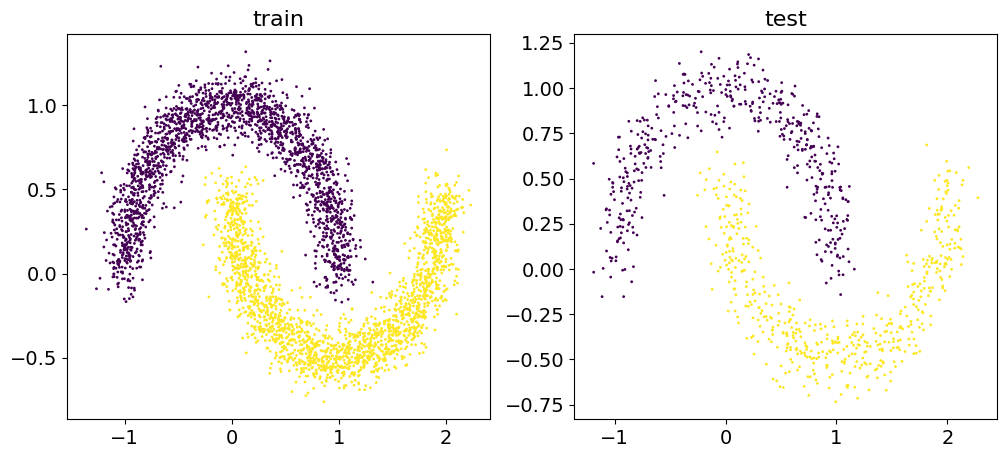

In [5]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Below you see the utility function, which broadcasts tensors. Look carefully at this code, we will use it in the majority of methods.

In [6]:
def _extract_into_tensor(arr, indices, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices to extract from arr.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]


    return res.expand(broadcast_shape)

### Forward Diffusion

Let start with forward diffusion.

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) := \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Now we will create base class for diffusion (we will use it as a python base class for forward and backward diffusions).

In [7]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)

    @staticmethod
    def _get_beta_schedule(num_diffusion_timesteps):
        assert num_diffusion_timesteps >= 20
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()
        betas = torch.from_numpy(betas).float()
        return betas


basediff = BaseDiffusion(num_timesteps=20)
basediff.betas

tensor([0.0050, 0.0574, 0.1097, 0.1621, 0.2145, 0.2668, 0.3192, 0.3716, 0.4239,
        0.4763, 0.5287, 0.5811, 0.6334, 0.6858, 0.7382, 0.7905, 0.8429, 0.8953,
        0.9476, 1.0000])

We are ready to define forward diffusion process. It has 2 methods:
- to get mean and variance of the distribution $q(\mathbf{x}_t | \mathbf{x}_0)$,
- to get samples from this distribution.

In [8]:
# class ForwardDiffusion(BaseDiffusion):
#     def get_mean_variance(self, x0, t):
#         shape = [x0.size(0)] + [1] * (x0.dim() - 1)  
#         device = x0.device
#         sqrt_alphas_cumprod = self.alphas_cumprod.sqrt().to(device)
#         alphas_cumprod_t = self.alphas_cumprod.to(device)[t]      
#         sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t]    
#         mean = sqrt_alphas_cumprod_t.view(*shape) * x0      
#         variance = (1.0 - alphas_cumprod_t).view(*shape).expand_as(x0)
#         return mean, variance

#     def get_samples(self, x0, t, noise=None):
#         shape = [x0.size(0)] + [1] * (x0.dim() - 1) 
#         device = x0.device
#         if noise is None:
#             noise = torch.randn_like(x0)
#         alphas_cumprod_t = self.alphas_cumprod.to(device)[t]                
#         sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod_t)    
#         sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod_t)
#         samples = sqrt_alphas_cumprod_t.view(*shape) * x0 + sqrt_one_minus_alphas_cumprod_t.view(*shape) * noise
#         return samples

class ForwardDiffusion(BaseDiffusion):
    def get_mean_variance(self, x0, t):
        # ====
        # your code
        # calculate mean and variance of the distribution q(x_t | x_0) (use equation (1))
        # use _extract_into_tensor() function to get tensors of the same shape as x0
        mean = _extract_into_tensor(torch.sqrt(self.alphas_cumprod), t, x0.shape)
        variance = _extract_into_tensor(1 - self.alphas_cumprod, t, x0.shape)
        # ====
        return mean, variance

    def get_samples(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        # ====
        # your code
        # sample from the distribution q(x_t | x_0) (use equation (2))

        # ====
        mean, variance = self.get_mean_variance(x0, t)
        samples = mean * x0 + torch.sqrt(variance) * noise
        return samples



def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9820154)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.03564582)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.numpy(), np.ones(SHAPE) * 1.1708164)


test_forward_diffusion()

Let visualize the forward diffusion process. Here you have to see how the distribution of the real samples transforms to the gaussian noise.

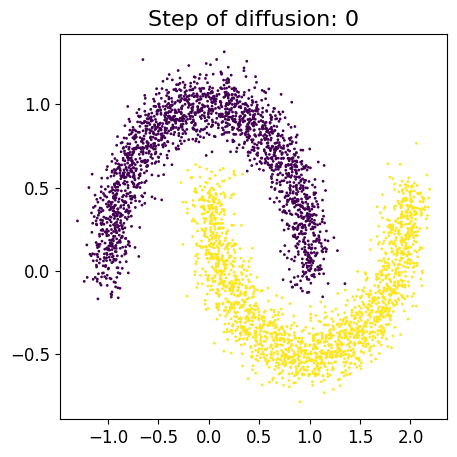

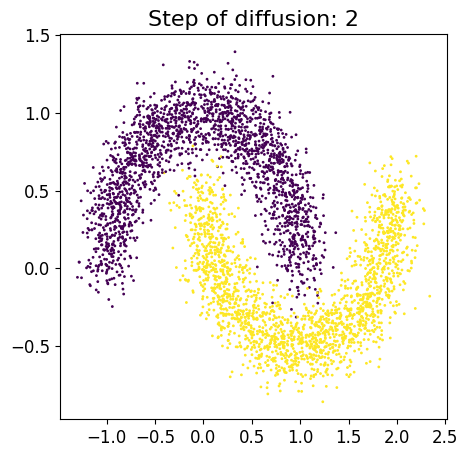

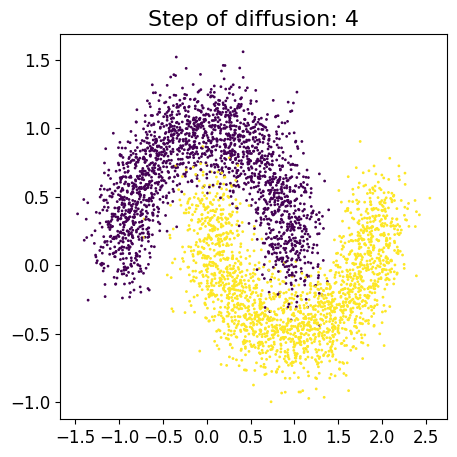

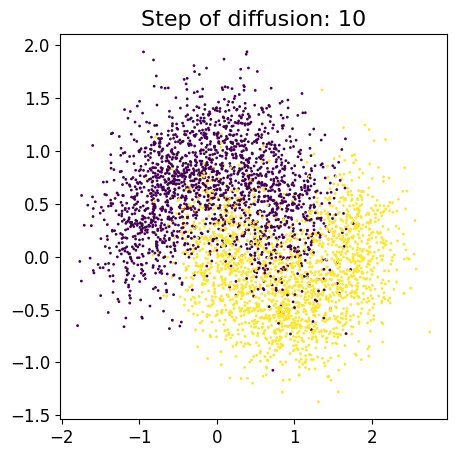

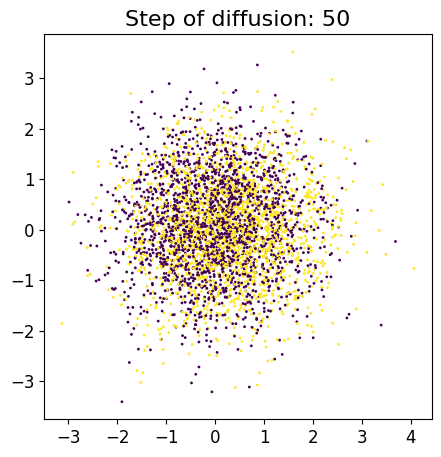

In [9]:
T = 100

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 2, 4, 10, 50]

plot_n_steps = len(timestamps)
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(train_data), t=torch.ones((train_data.shape[0], 1)).long() * t)
    visualize_2d_samples(x, title=f"Step of diffusion: {t}", labels=train_labels)

### Reverse Diffusion

**Reverse process** consequently denoises pure gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of gaussian distributions $p(\mathbf{x}_{i-1}|\mathbf{x}_{i}, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(\mathbf{x}_T | 0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\mathbf{x}_{t - 1}| \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)). \tag{3}
$$

In Lecture 12 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbb{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \right).
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [10]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

        # ====
        # your code
        # calculate variance of the distribution q(x_{t-1} | x_t, x_0) mean (use equation (5))
        self.variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
        # ====
        # first value is zero, futher we will take log of this expression, so we will replace first value by the second value.
        # self.variance_clipped = torch.cat([variance[1:2], variance[1:]], dim=0)

        # ====
        # your code
        # calculate coefficients of the distribution q(x_{t-1} | x_t, x_0) mean (use equation (4))
        self.xt_coef = torch.sqrt(self.alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        self.x0_coef = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt, eps, t):
        # ====
        # your code
        # get x_0 (use equation (6))
        # ====

        sqrt_alphas_cumprod = _extract_into_tensor(torch.sqrt(self.alphas_cumprod), t, xt.shape)
        sqrt_1m_alphas_cumprod = _extract_into_tensor(torch.sqrt(1 - self.alphas_cumprod), t, xt.shape)

        x0 = (xt - sqrt_1m_alphas_cumprod * eps) / sqrt_alphas_cumprod
        
        # shape = [xt.size(0)] + [1] * (xt.dim() - 1) 
        # device = xt.device

        
        # x0 = (xt - torch.sqrt(1 - self.alphas_cumprod.to(device)[t].view(*shape)) * eps) / torch.sqrt(self.alphas_cumprod.to(device)[t].view(*shape))
        return x0

    def get_mean_variance(self, xt, eps, t):
        # ====
        # your code
        # get mean and variance of the distribution q(x_{t-1} | x_t, x_0) mean (use equations (4) and (5))

        # ====
        # shape = [xt.size(0)] + [1] * (xt.dim() - 1)
        # device = xt.device
        # a = self.xt_coef.to(device)[t].view(*shape)
        # b = self.x0_coef.to(device)[t].view(*shape)

        a = _extract_into_tensor(self.xt_coef, t, xt.shape)
        b = _extract_into_tensor(self.x0_coef, t, xt.shape)
        
        
        mean = a * xt + b * self.get_x0(xt, eps, t)
        
        # variance = self.variance_clipped.to(device)[t].view(*shape).expand_as(mean)

        variance = _extract_into_tensor(self.variance, t, xt.shape)
        
        return mean, variance

    def get_samples(self, xt, eps, t):
        # read this code carefully
        mean, variance = self.get_mean_variance(xt=xt, eps=eps, t=t)
        noise = torch.randn_like(xt, device=xt.device)

        nonzero_mask = torch.ones_like(t)  # to not add any noise while predicting x0
        nonzero_mask[t == 0] = 0
        nonzero_mask = _extract_into_tensor(
            nonzero_mask, torch.arange(nonzero_mask.shape[0]), xt.shape
        )
        nonzero_mask = nonzero_mask.to(xt.device)
        sample = mean + nonzero_mask * variance.sqrt() * noise
        return sample.float()


def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE)
    eps = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.numpy(), np.ones(SHAPE) * 0.8260552)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.numpy(), np.ones(SHAPE) * 0.9467155)
    assert np.allclose(variance.numpy(), np.ones(SHAPE) * 0.007709955)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE


test_reverse_diffusion()

### Model

In this task we will use simple MLP model to parametrize distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t, \boldsymbol{\theta})$. It will be conditioned on the timestamps.

In [11]:
class ConditionalMLP(nn.Module):
    def __init__(self, input_dim: int, num_embeds: int, hidden_dim: int = 128):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(input_dim, self.hidden_dim)
        self.t_proj = nn.Embedding(num_embeds, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, 2 * self.hidden_dim),
            nn.GELU(),
            nn.Linear(2 * self.hidden_dim, input_dim),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t):
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        x = x + t
        x = F.gelu(x)
        return self.backbone(x)


def test_conditional_mlp():
    SHAPE = [2, 20]
    T = 100
    x = torch.ones(SHAPE)
    t = torch.ones((2,)).long() * 5
    model = ConditionalMLP(input_dim=20, num_embeds=100)
    output = model(x, t)
    assert list(output.shape) == SHAPE


test_conditional_mlp()

### DDPM

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

In Lecture 12 we have got that
$$
    \mathcal{L}_t = \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

The following class implements two methods:
- `train_loss` - to compute the loss at the training step;
- `sample` - to sample from the final model.

In [12]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @property
    def device(self):
        return next(self.parameters()).device

    def sample(self, num_samples):
        assert self.shape is not None
        x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = torch.tensor([i] * num_samples, device=x.device)
            with torch.no_grad():
                # ====
                # your code
                # 1) get epsilon from the model
                # 2) sample from the reverse diffusion
                
                # ====
                eps_pred = self.model(x, t)
                x = self.reverse_diffusion.get_samples(x, eps_pred, t)
                
        return x

    def train_loss(self, x0):
        if self.shape is None:
            self.shape = list(x0.shape)[1:]
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)

        # ====
        # your code
        # 1) get x_t
        # 2) get epsilon from the model
        x_t = self.forward_diffusion.get_samples(x0, t, noise=noise)
        eps = self.model(x_t, t)

        # ====
        loss = F.mse_loss(eps, noise)
        return loss

### Training

Now we are ready to train our model.

In [13]:
def train_model(
    ddpm: DDPM,
    dataloader,
    lr: float,
    weight_decay: float,
    steps: int,
    use_cuda: bool,
    log_every: int = 500
):

    def _anneal_lr(step: int):
        frac_done = step / steps
        current_lr = lr * (1 - frac_done)
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr

    if use_cuda:
        ddpm = ddpm.cuda()
    optimizer = torch.optim.AdamW(
        ddpm.model.parameters(), lr=lr, weight_decay=weight_decay
    )
    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < steps:
        try:
            x = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            x = next(data_iter)

        if USE_CUDA:
            x = x.cuda()

        loss = ddpm.train_loss(x)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _anneal_lr(step)

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{steps} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

In [14]:
T = 100
# ====
# your code
# choose these parameters
BATCH_SIZE = 512
LR = 1e-2
WEIGHT_DECAY = 0.0
STEPS = 10000
# ====

model = ConditionalMLP(input_dim=2, num_embeds=T)
ddpm = DDPM(num_timesteps=T, model=model)

dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    steps=STEPS,
    use_cuda=USE_CUDA
)

Step 500/10000 Loss: 0.2135
Step 1000/10000 Loss: 0.1967
Step 1500/10000 Loss: 0.1952
Step 2000/10000 Loss: 0.1946
Step 2500/10000 Loss: 0.1939
Step 3000/10000 Loss: 0.193
Step 3500/10000 Loss: 0.1914
Step 4000/10000 Loss: 0.1912
Step 4500/10000 Loss: 0.1902
Step 5000/10000 Loss: 0.1879
Step 5500/10000 Loss: 0.1891
Step 6000/10000 Loss: 0.1885
Step 6500/10000 Loss: 0.1888
Step 7000/10000 Loss: 0.1871
Step 7500/10000 Loss: 0.1862
Step 8000/10000 Loss: 0.1847
Step 8500/10000 Loss: 0.1845
Step 9000/10000 Loss: 0.1859
Step 9500/10000 Loss: 0.1862
Step 10000/10000 Loss: 0.1832


Now let's sample from our trained model.

100%|██████████| 100/100 [00:00<00:00, 417.83it/s]


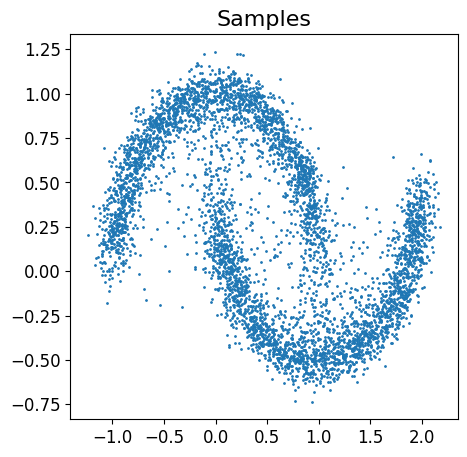

In [15]:
samples = ddpm.sample(num_samples=5000).cpu()

visualize_2d_samples(samples, title="Samples")

Now let's see how denoising looks like (similarly to forward noising process).

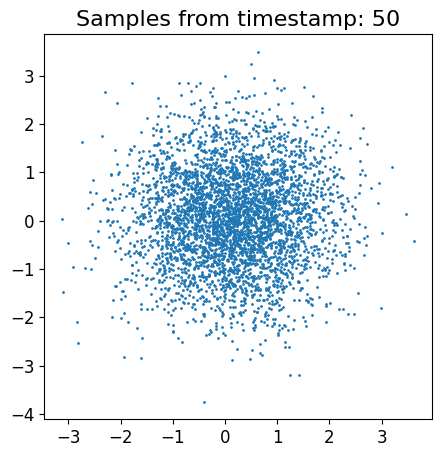

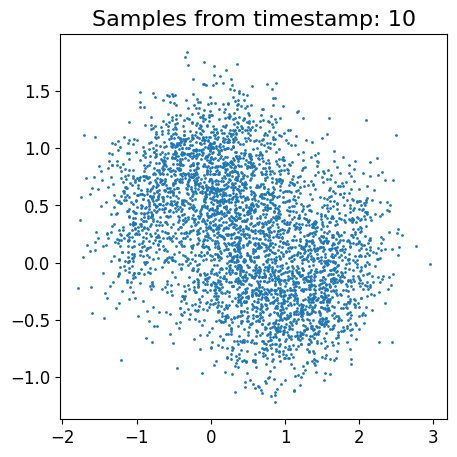

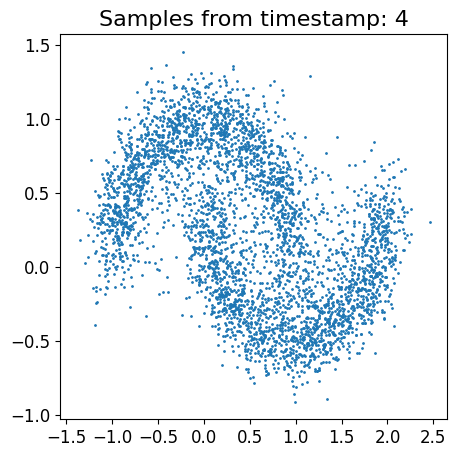

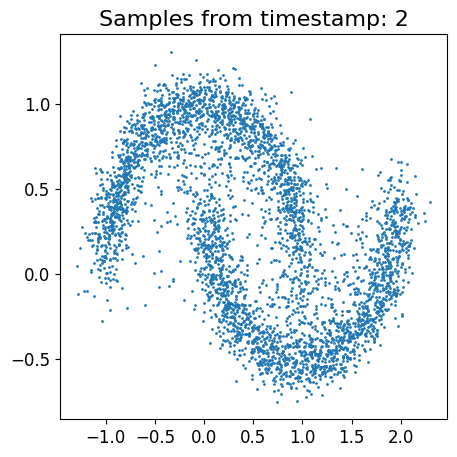

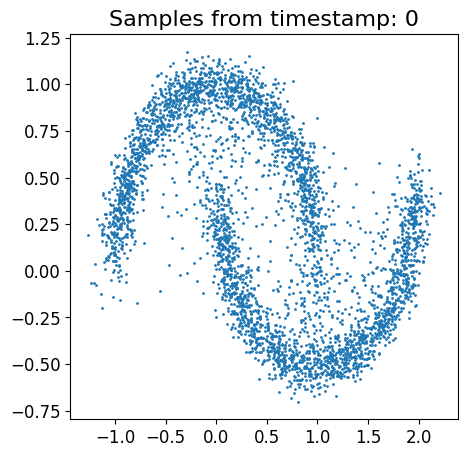

In [16]:
timestamps=[0, 2, 4, 10, 50]

x = torch.randn(train_data.shape[0], 2, requires_grad=False).to(ddpm.device)
for i in range(ddpm.num_timesteps - 1, -1, -1):
    t = torch.tensor(i, dtype=torch.long, requires_grad=False).expand(x.shape[0]).to(ddpm.device)
    with torch.no_grad():
        eps = ddpm.model(x, t)
        x = ddpm.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
    if i in reversed(timestamps):
        x_ = x.cpu()
        visualize_2d_samples(x_, title=f"Samples from timestamp: {i}")

## Task3: DDPM on MNIST (4pt)

Let apply our diffusion model to the MNIST dataset.

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



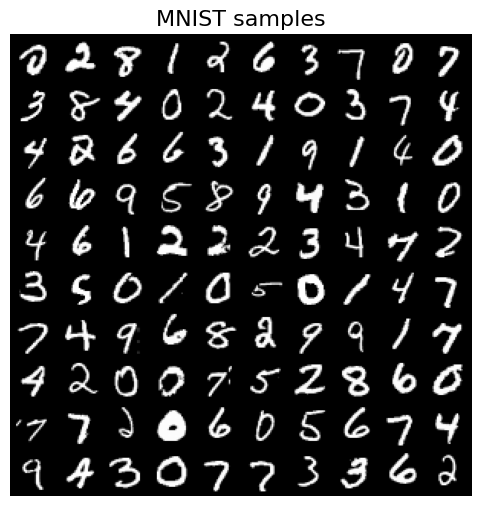

In [17]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)

visualize_images(train_data, "MNIST samples")

DATA_MEAN = train_data.mean()
DATA_STD = train_data.std()

train_data = (train_data - DATA_MEAN) / DATA_STD

Let's take a look at the forward process for the MNIST images.

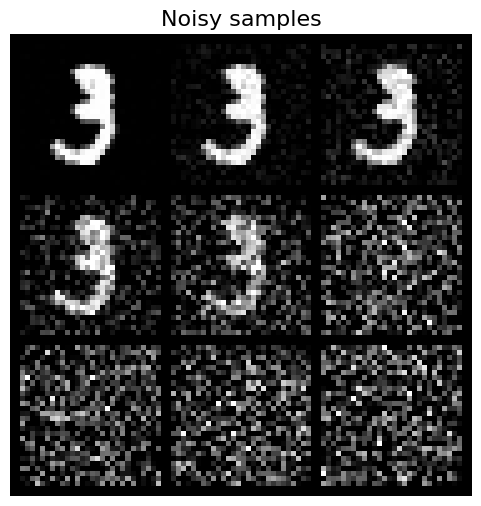

In [18]:
T = 1000

fdiff = ForwardDiffusion(num_timesteps=T)

timestamps=[0, 50, 100, 200, 300, 500, 600, 800, 999]

plot_n_steps = len(timestamps)
samples = []
x0 = train_data[10:11]
for i, t in enumerate(timestamps):
    x = fdiff.get_samples(x0=torch.from_numpy(x0), t=torch.ones((x0.shape[0], 1)).long() * t)
    samples.append(x.cpu().numpy())

samples = np.concatenate(samples)
samples = samples * DATA_STD + DATA_MEAN
show_samples(samples, title="Noisy samples")

The model is written for you. We will use UNet architecture.

In [21]:
class ConditionedResnetBlock(nn.Module):
    def __init__(self, dim: int, num_embeddings: int) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
        )
        self.dim = dim
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        time_embed = self.embedding(y).view(-1, self.dim, 1, 1)
        return x + self.block(x + time_embed)


class ConditionedSimpleResnet(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, n_filters: int, n_blocks: int, num_embeddings: int
    ) -> None:
        super().__init__()
        # you could experiment with this architecture
        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.layers = nn.Sequential(*[ConditionedResnetBlock(n_filters, num_embeddings) for _ in range(n_blocks)])
        self.last_block = nn.Sequential(
            nn.ReLU(), nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)
        )
        self.n_filters = n_filters

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = self.first_block(x)
        for layer in self.layers:
            x = layer(x, t)
        x = self.last_block(x)
        return x


def test_conditioned_resnet():
    model = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=16, n_blocks=1, num_embeddings=2)
    x = torch.rand((1, 1, 28, 28))
    t = torch.zeros(size=(1,), dtype=torch.long)
    out1 = model(x, t)
    t = torch.ones(size=(1,), dtype=torch.long)
    out2 = model(x, t)
    assert not np.allclose(out1.detach().numpy(), out2.detach().numpy())


test_conditioned_resnet()

In [20]:
from unet import MyUNet

In this task you just have to train the model. All previous parts of the pipeline will be the same.

In [20]:
class DDPMMNIST(DDPM):
    @torch.no_grad()
    def sample(self, num_samples: int):
        x = super().sample(num_samples)
        return torch.clamp(0.5 * x + 0.5, -1.0, 1.0)

    def loss(self, x0):
        x0 = 2.0 * x0 - 1.0
        return super().loss(x0)

In [24]:
T = 1000
# ====
# your code
# choose these parameters
BATCH_SIZE = 256
LR = 5e-4
WEIGHT_DECAY = 0.97
STEPS = 10000

N_FILTERS = 256
N_BLOCKS = 4
# ====


dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# model_mnist = MyUNet(n_steps=T)
model_mnist = ConditionedSimpleResnet(in_channels=1, out_channels=1, n_filters=N_FILTERS, n_blocks=N_BLOCKS, num_embeddings=T)
# ddpm_mnist = DDPM(num_timesteps=T, model=model_mnist)
ddpm_mnist = DDPMMNIST(num_timesteps=T, model=model_mnist)

train_model(
    ddpm=ddpm_mnist,
    dataloader=dataloader,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    steps=STEPS,
    use_cuda=USE_CUDA,
    log_every=200
)

Step 200/10000 Loss: 0.1647
Step 400/10000 Loss: 0.0609
Step 600/10000 Loss: 0.0507
Step 800/10000 Loss: 0.0473
Step 1000/10000 Loss: 0.0455
Step 1200/10000 Loss: 0.0445
Step 1400/10000 Loss: 0.0431
Step 1600/10000 Loss: 0.0431
Step 1800/10000 Loss: 0.0425
Step 2000/10000 Loss: 0.0415
Step 2200/10000 Loss: 0.0407
Step 2400/10000 Loss: 0.0402
Step 2600/10000 Loss: 0.0401
Step 2800/10000 Loss: 0.0395
Step 3000/10000 Loss: 0.0396
Step 3200/10000 Loss: 0.0393
Step 3400/10000 Loss: 0.0387
Step 3600/10000 Loss: 0.0382
Step 3800/10000 Loss: 0.0387
Step 4000/10000 Loss: 0.0384
Step 4200/10000 Loss: 0.0378
Step 4400/10000 Loss: 0.0376
Step 4600/10000 Loss: 0.0376
Step 4800/10000 Loss: 0.0373
Step 5000/10000 Loss: 0.0373
Step 5200/10000 Loss: 0.0372
Step 5400/10000 Loss: 0.0369
Step 5600/10000 Loss: 0.0368
Step 5800/10000 Loss: 0.0367
Step 6000/10000 Loss: 0.0361
Step 6200/10000 Loss: 0.036
Step 6400/10000 Loss: 0.0359
Step 6600/10000 Loss: 0.0357
Step 6800/10000 Loss: 0.0357
Step 7000/10000 Los

Let's draw samples from the trained model.

100%|██████████| 1000/1000 [00:12<00:00, 77.20it/s]


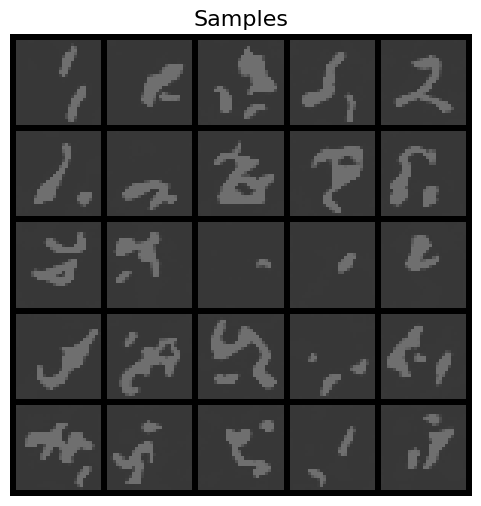

In [25]:
if USE_CUDA:
    ddpm_mnist = ddpm_mnist.cuda()

with torch.no_grad():
    samples = ddpm_mnist.sample(num_samples=25).cpu().numpy()

samples = samples * DATA_STD + DATA_MEAN

show_samples(samples, title="Samples")

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_ddpm_samples(samples, nrow=5, ncol=5, figsize=(6,6)):
    if isinstance(samples, torch.Tensor):
        imgs = samples.detach().cpu().numpy()
    else:
        imgs = samples
    
    if imgs.ndim == 4 and imgs.shape[1] == 1:
        imgs = imgs[:, 0] 
    
    if imgs.min() < 0:
        imgs = (imgs + 1) / 2
    imgs = np.clip(imgs, 0, 1)
    
    N, H, W = imgs.shape
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i < N:
            ax.imshow(imgs[i], cmap='gray', interpolation='nearest')
        else:
            ax.set_visible(False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


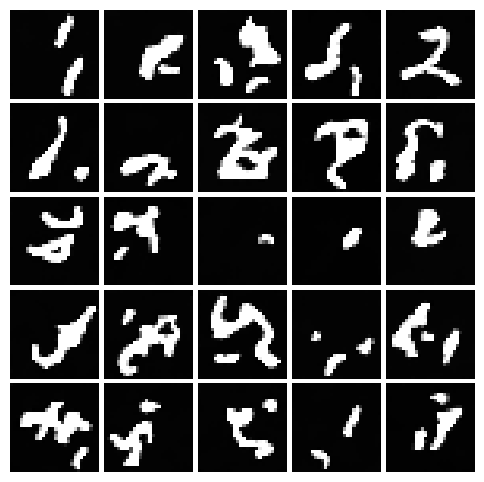

In [29]:
visualize_ddpm_samples(samples)